In [1]:
#data related imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

# classification model imports
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# deep learning model imports
from keras.callbacks import EarlyStopping
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


#visualizations
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # <-- needed for 3D plotting
from matplotlib.cm import viridis

import time

import joblib



In [2]:
df = pd.read_csv('E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv', low_memory=False)

In [3]:
print(df.isnull().sum())

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64


In [4]:
print(df.duplicated().sum())

814


In [5]:
#because it takes a lot of time to train the svm on the wholedataset. on internet, it was recommended to train it on a shorter dataset and then test it.

df = df.sample(frac=0.35, random_state=42)  # random_state for reproducibility

In [6]:
# Drop rows with missing values
df.dropna(inplace=True)
method_encoder = LabelEncoder()


# Fit and transform
df['http.request.method_encoded'] = method_encoder.fit_transform(df['http.request.method'].astype(str))
df['http.request.version_encoded'] = np.where(df['http.request.version'].astype(str).str.strip() == '0', 0, 1)
df['mqtt_topic'] = method_encoder.fit_transform(df['mqtt.topic'].astype(str))
df['mqtt_protoname'] = method_encoder.fit_transform(df['mqtt.protoname'].astype(str))
df['Attack_type'] = np.where(df['Attack_type'].astype(str).str.strip() == 'normal', 0, 1)

# Step 1: Drop object columns
X = df.drop(columns=[
    'Attack_label','http.request.full_uri', 'http.referer', 'http.file_data', 
    'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
    'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
    'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
    'dns.qry.name.len','mqtt.conack.flags'
])

# Step 2: Set target
y = df['Attack_label']

# Train-val-test split: 70/20/10

# First split: Train 70%, Temp 30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Second split: Validation 20% (2/3 of 30%), Test 10% (1/3 of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [7]:
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Train class distribution:
 Attack_label
1    32663
0     5998
Name: count, dtype: int64
Validation class distribution:
 Attack_label
1    9332
0    1714
Name: count, dtype: int64
Test class distribution:
 Attack_label
1    4666
0     857
Name: count, dtype: int64


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55230 entries, 23552 to 122685
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   arp.opcode                    55230 non-null  float64
 1   arp.hw.size                   55230 non-null  float64
 2   icmp.checksum                 55230 non-null  float64
 3   icmp.seq_le                   55230 non-null  float64
 4   icmp.transmit_timestamp       55230 non-null  float64
 5   icmp.unused                   55230 non-null  float64
 6   http.content_length           55230 non-null  float64
 7   http.response                 55230 non-null  float64
 8   http.tls_port                 55230 non-null  float64
 9   tcp.ack                       55230 non-null  float64
 10  tcp.ack_raw                   55230 non-null  float64
 11  tcp.checksum                  55230 non-null  float64
 12  tcp.connection.fin            55230 non-null  float64
 13  t

# Support Vector Machine

In [9]:
# Train the SVM model
start_time_svm = time.time()

svm = LinearSVC( max_iter=1000, C=1.0, verbose=True)
svm.fit(X_train, y_train)

end_time_svm = time.time()

training_duration_svm = end_time_svm - start_time_svm


joblib.dump(svm, 'svm_model.joblib')

C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['svm_model.joblib']

In [10]:
# Predict
y_pred = svm.predict(X_test)

In [11]:
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print(f"training duration: {training_duration_svm}")

Confusion Matrix:
 [[ 727  130]
 [   2 4664]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92       857
           1       0.97      1.00      0.99      4666

    accuracy                           0.98      5523
   macro avg       0.99      0.92      0.95      5523
weighted avg       0.98      0.98      0.98      5523


Accuracy Score: 0.9760999456816948
training duration: 2.9491076469421387


In [12]:
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)



In [13]:

cmap = plt.cm.viridis

true_colors = np.array([cmap(float(c)) for c in y_test])
pred_colors = np.array([cmap(float(c)) for c in y_pred])

wrong_mask = (y_pred != y_test)
pred_colors[wrong_mask] = np.array([1, 0, 0, 1])  # red for wrong preds


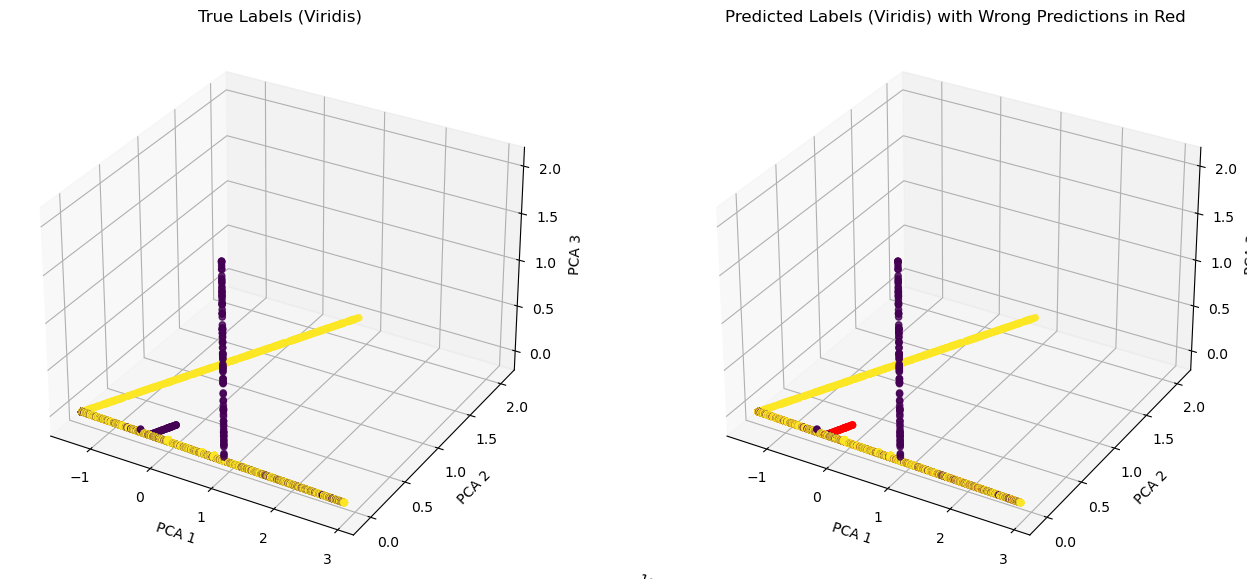

In [14]:
# Plot side by side
fig = plt.figure(figsize=(16,7))

# True labels plot
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=true_colors, alpha=0.8)
ax1.set_title("True Labels (Viridis)")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_zlabel("PCA 3")

# Predicted labels plot with red wrong preds
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=pred_colors, alpha=0.8)
ax2.set_title("Predicted Labels (Viridis) with Wrong Predictions in Red")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")

plt.show()

# decision tree classifier

In [ ]:
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

In [ ]:
print("X shape:", X.shape)
print("X columns:", X.columns.tolist())

In [ ]:



model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,       # Disable the label encoder warning
    objective='binary:logistic',   # Important: binary classification objective
    eval_metric='logloss'          # Evaluation metric
)

# Start timer
start_time = time.time()

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True  # Optional: shows training log
)

# End timer
end_time = time.time()

model.save_model("xgb_model.json")

# upload_file(
#     path_or_fileobj="xgb_model.json",  # or "xgb_model.pkl"
#     path_in_repo="xgb_model.json",     # File name in the repo
#     repo_id="ScHemer34/DT_XGBoost",
#     repo_type="model"
# )


In [ ]:
y_pred = model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['normal', 'attack']))

# Print duration
training_duration = end_time - start_time
print(f"\n✅ Model trained in {training_duration:.2f} seconds")

# Dataset for Deep Learning Models

In [2]:
df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path
print(df_fnn.shape)
df_fnn.info()



C:\Users\afnan\AppData\Local\Temp\ipykernel_9276\2324740219.py:1: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path


(2219201, 63)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 63 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   frame.time                 object 
 1   ip.src_host                object 
 2   ip.dst_host                object 
 3   arp.dst.proto_ipv4         object 
 4   arp.opcode                 float64
 5   arp.hw.size                float64
 6   arp.src.proto_ipv4         object 
 7   icmp.checksum              float64
 8   icmp.seq_le                float64
 9   icmp.transmit_timestamp    float64
 10  icmp.unused                float64
 11  http.file_data             object 
 12  http.content_length        float64
 13  http.request.uri.query     object 
 14  http.request.method        object 
 15  http.referer               object 
 16  http.request.full_uri      object 
 17  http.request.version       object 
 18  http.response              float64
 19  http.tls_port              f

In [3]:
# Drop rows with missing values
df_fnn.dropna(inplace=True)

#encoding important columns
# Initialize encoder
method_encoder = LabelEncoder()

# Fit and transform
df_fnn['http.request.method_encoded'] = method_encoder.fit_transform(df_fnn['http.request.method'].astype(str))
df_fnn['http.request.version_encoded'] = np.where(df_fnn['http.request.version'].astype(str).str.strip() == '0', 0, 1)
df_fnn['mqtt_topic'] = method_encoder.fit_transform(df_fnn['mqtt.topic'].astype(str))
df_fnn['mqtt_protoname'] = method_encoder.fit_transform(df_fnn['mqtt.protoname'].astype(str))
df_fnn['Attack_type'] = np.where(df_fnn['Attack_type'].astype(str).str.strip() == 'normal', 0, 1)


# Step 2: Set target
y_fnn = df_fnn['Attack_label']

# Now drop object and unnecessary columns
X_fnn = df_fnn.drop(columns=[
    'Attack_label', 'http.request.full_uri', 'http.referer', 'http.file_data', 
    'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
    'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
    'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
    'dns.qry.name.len','mqtt.conack.flags'
])

In [4]:

# First split: Train 70%, Temp 30%
X_train_fnn, X_temp_fnn, y_train_fnn, y_temp_fnn = train_test_split(
    X_fnn, y_fnn, test_size=0.3, stratify=y_fnn, random_state=42
)

# Second split: Validation 20% (2/3 of 30%), Test 10% (1/3 of 30%)
X_val_fnn, X_test_fnn, y_val_fnn, y_test_fnn = train_test_split(
    X_temp_fnn, y_temp_fnn, test_size=1/3, stratify=y_temp_fnn, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train_fnn = X_train_fnn.reset_index(drop=True)
X_val_fnn = X_val_fnn.reset_index(drop=True)
X_test_fnn = X_test_fnn.reset_index(drop=True)

y_train_fnn = y_train_fnn.reset_index(drop=True)
y_val_fnn = y_val_fnn.reset_index(drop=True)
y_test_fnn = y_test_fnn.reset_index(drop=True)


In [5]:
overlap = set(map(tuple, X_train_fnn.values)) & set(map(tuple, X_val_fnn.values))
print(f"Train/Val Overlap: {len(overlap)}")  # Should be 0

Train/Val Overlap: 69374


In [6]:
print("Train class distribution:\n", y_train_fnn.value_counts())
print("Validation class distribution:\n", y_val_fnn.value_counts())
print("Test class distribution:\n", y_test_fnn.value_counts())

Train class distribution:
 Attack_label
0    1130950
1     422490
Name: count, dtype: int64
Validation class distribution:
 Attack_label
0    323128
1    120712
Name: count, dtype: int64
Test class distribution:
 Attack_label
0    161565
1     60356
Name: count, dtype: int64


# Feed Forward Neural Network

In [3]:
import torch.nn as nn


class LinearNN(nn.Module):
    def __init__(self, input_size):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(16, 8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.output = nn.Linear(8, 1)  # Output = 1 for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.output(x)  # No sigmoid here if using BCEWithLogitsLoss
        return x

In [7]:
#normalize the data
# scaler = StandardScaler()
# X_train_fnn = scaler.fit_transform(X_train_fnn)
# X_val_fnn = scaler.transform(X_val_fnn)
# X_test_fnn = scaler.transform(X_test_fnn)

print(X_fnn.dtypes[X_fnn.dtypes == 'object'])

# convert dataframe to pytorch tensors
X_train_tensor_fnn = torch.tensor(X_train_fnn.to_numpy(), dtype=torch.float32)
y_train_tensor_fnn = torch.tensor(y_train_fnn.to_numpy(), dtype=torch.float32)

X_val_tensor_fnn = torch.tensor(X_val_fnn.to_numpy(), dtype=torch.float32)
y_val_tensor_fnn = torch.tensor(y_val_fnn.to_numpy(), dtype=torch.float32)

Series([], dtype: object)


In [8]:
# Start timer
start_time_fnn = time.time()

model_fnn = LinearNN(input_size=X_train_fnn.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_fnn.parameters(), lr=0.0001)

num_epochs = 30
for epoch in range(num_epochs):
    model_fnn.train()
    
    outputs = model_fnn(X_train_tensor_fnn).squeeze()
    loss = criterion(outputs, y_train_tensor_fnn.float())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Calculate validation loss
    model_fnn.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients during validation
        val_outputs = model_fnn(X_val_tensor_fnn).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor_fnn.float())

    # Print epoch information
    model_fnn.train()  # Set model back to training mode
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


# End timer
end_time_fnn = time.time()

torch.save(model_fnn.state_dict(), "linear_nn_model.pth")

Epoch [1/30], Loss: 14127033.0000, Val Loss: 14088618.0000
Epoch [2/30], Loss: 14086947.0000, Val Loss: 14048589.0000
Epoch [3/30], Loss: 14046937.0000, Val Loss: 14008634.0000
Epoch [4/30], Loss: 14007001.0000, Val Loss: 13968753.0000
Epoch [5/30], Loss: 13967140.0000, Val Loss: 13928954.0000
Epoch [6/30], Loss: 13927359.0000, Val Loss: 13889229.0000
Epoch [7/30], Loss: 13887656.0000, Val Loss: 13849585.0000
Epoch [8/30], Loss: 13848032.0000, Val Loss: 13810023.0000
Epoch [9/30], Loss: 13808487.0000, Val Loss: 13770543.0000
Epoch [10/30], Loss: 13769025.0000, Val Loss: 13731145.0000
Epoch [11/30], Loss: 13729648.0000, Val Loss: 13691829.0000
Epoch [12/30], Loss: 13690354.0000, Val Loss: 13652601.0000
Epoch [13/30], Loss: 13651143.0000, Val Loss: 13613455.0000
Epoch [14/30], Loss: 13612017.0000, Val Loss: 13574398.0000
Epoch [15/30], Loss: 13572977.0000, Val Loss: 13535428.0000
Epoch [16/30], Loss: 13534027.0000, Val Loss: 13496546.0000
Epoch [17/30], Loss: 13495163.0000, Val Loss: 134

In [9]:
model_fnn.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_fnn.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_fnn.values, dtype=torch.float32)

    outputs = model_fnn(X_test_tensor).squeeze()
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

    correct = (preds == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.shape[0]

print(f"\n🧪 Test Accuracy: {accuracy:.4f}")

# Print duration
training_duration_fnn = end_time_fnn - start_time_fnn
print(f"⏱️ Model trained in {training_duration_fnn:.2f} seconds")


🧪 Test Accuracy: 0.7280
⏱️ Model trained in 12.76 seconds


# Convolutional Neural Network

In [7]:
# Convert to numpy arrays
X_train = X_train_fnn.to_numpy()
X_val = X_val_fnn.to_numpy()
X_test = X_test_fnn.to_numpy()
y_train = y_train_fnn.to_numpy()
y_val = y_val_fnn.to_numpy()
y_test = y_test_fnn.to_numpy()

In [8]:
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [10]:
# Build CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use 1 and sigmoid for binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train model
start_time_cnn = time.time()

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)
end_time_cnn = time.time()

training_duration_cnn = end_time_cnn - start_time_cnn


Epoch 1/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 224s 5ms/step - accuracy: 0.9980 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 4.1240e-13
Epoch 2/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 218s 4ms/step - accuracy: 1.0000 - loss: 5.6970e-10 - val_accuracy: 1.0000 - val_loss: 1.1868e-17
Epoch 3/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 258s 4ms/step - accuracy: 1.0000 - loss: 2.1597e-11 - val_accuracy: 1.0000 - val_loss: 2.7076e-16
Epoch 4/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 188s 4ms/step - accuracy: 1.0000 - loss: 1.7777e-11 - val_accuracy: 1.0000 - val_loss: 1.2721e-17
Epoch 5/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 211s 4ms/step - accuracy: 1.0000 - loss: 3.4530e-12 - val_accuracy: 1.0000 - val_loss: 3.6522e-18
Epoch 6/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 266s 4ms/step - accuracy: 1.0000 - loss: 4.9038e-10 - val_accuracy: 1.0000 - val_loss: 7.7504e-17
Epoch 7/10
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 216s 4ms/step - accuracy: 1.0000 - loss: 8.6797e-11 - val_accuracy: 1.0000 - val_loss: 1.9568e-18
Epoch 8/10

In [12]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

6936/6936 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 1.0000 - loss: 1.8552e-19

Test Accuracy: 1.0000
Test Loss: 0.0000


In [13]:
# Predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)


6936/6936 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [14]:
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    161565
           1       1.00      1.00      1.00     60356

    accuracy                           1.00    221921
   macro avg       1.00      1.00      1.00    221921
weighted avg       1.00      1.00      1.00    221921



In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

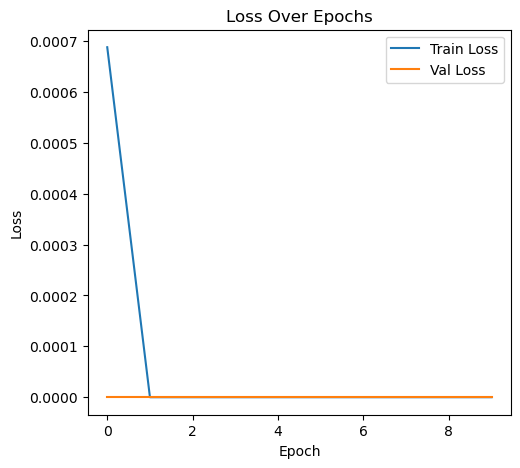

In [16]:
# Plot training/validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

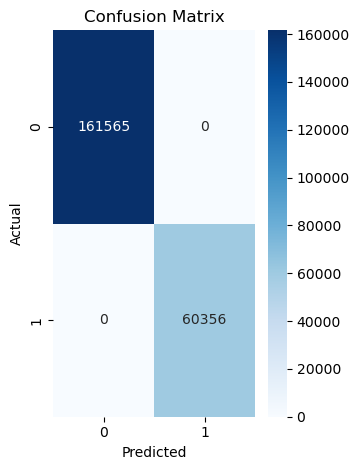

In [19]:
import seaborn as sns
# Plot confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [18]:
# Save the model to an HDF5 file
model.save("cnn_model.h5")

# Long Short Term Memory


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [8]:
timesteps = 1

num_features = X_train_fnn.shape[1]

# --- Step 1: Convert DataFrames to NumPy Arrays ---
X_train_np = X_train_fnn.to_numpy()
y_train_np = y_train_fnn.to_numpy().reshape(-1, 1)

X_val_np = X_val_fnn.to_numpy()
y_val_np = y_val_fnn.to_numpy().reshape(-1, 1)

# --- Step 2: Scale Features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled = scaler.transform(X_val_np)  # use transform only on val

X_train_lstm = X_train_scaled.reshape(-1, timesteps, num_features)
X_val_lstm = X_val_scaled.reshape(-1, timesteps, num_features)


In [9]:
intersection = set(map(tuple, X_train_np)) & set(map(tuple, X_val_np))
print(f"Overlapping samples: {len(intersection)}")

Overlapping samples: 69374


In [9]:
# ---------- 2. Define LSTM model ----------
model = Sequential()
model.add(LSTM(32, return_sequences=False, input_shape=(timesteps, num_features)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Step 5: Train
start_time_lstm = time.time()
history = model.fit(
    X_train_lstm, 
    y_train_np,                # use y_full if labels are binary
    validation_data=(X_val_lstm, y_val_np), #validation checking dataset
    epochs=2,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
end_time_lstm = time.time()
training_duration_lstm = end_time_lstm - start_time_lstm
print(f"training duration is: {training_duration_lstm}")

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
24273/24273 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.9887 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 1.8871e-11
Epoch 2/2
24273/24273 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 1.0000 - loss: 2.8114e-08 - val_accuracy: 1.0000 - val_loss: 1.0822e-13
training duration is: 98.37376022338867


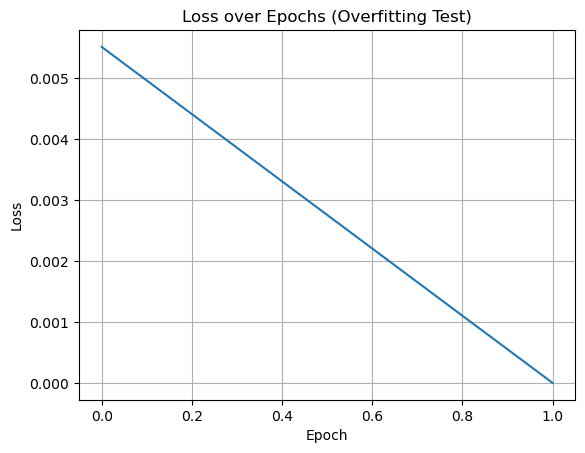

In [10]:
# ---------- 4. Check loss over time ----------

plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [11]:
print("x_test_fnn shape:", X_test_fnn.shape)
print("timesteps:", timesteps)
print("num_features:", num_features)

x_test_fnn shape: (221921, 46)
timesteps: 1
num_features: 46


In [12]:
X_test_array = X_test_fnn.to_numpy()  # Convert to numpy array
y_test_np = y_test_fnn.to_numpy().reshape(-1, 1)

# Check shape of X_test_array
print("X_test_array shape:", X_test_array.shape)

# Reshape to (samples, timesteps, num_features)
X_test_lstm = X_test_array.reshape((X_test_array.shape[0], timesteps, num_features))
print("X_test_lstm shape:", X_test_lstm.shape)

X_test_array shape: (221921, 46)
X_test_lstm shape: (221921, 1, 46)


In [13]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_np, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict
y_pred_prob = model.predict(X_test_lstm)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_np, y_pred))

6936/6936 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8258 - loss: 1.9018
Test Loss: 1.8798
Test Accuracy: 0.8270
6936/6936 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.96      0.89    161565
           1       0.81      0.47      0.60     60356

    accuracy                           0.83    221921
   macro avg       0.82      0.72      0.74    221921
weighted avg       0.83      0.83      0.81    221921



In [14]:
model.save("lstm_edge_model.h5")

In [20]:
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_test_np shape:", y_test_np.shape)
print("X_test_lstm dtype:", X_test_lstm.dtype)
print("y_test_np dtype:", y_test_np.dtype)

X_test_lstm shape: (221921, 1, 46)
y_test_np shape: (221921,)
X_test_lstm dtype: float64
y_test_np dtype: int64


# CNN + LSTM Hybrid
